PROJECT_ROOT: c:\Users\asus\OneDrive\EV-projects\evcs-projects
MODE: integer
Loaded: c:\Users\asus\OneDrive\EV-projects\evcs-projects\data\instances\inst_N80_seed11.json
P_sites(default)=7  -> using P=14  | Q=34.286  D=2.0
score_exact: 238.9776774215184
score_LS   : 238.97767742151822
score_DR   : 238.97767742151822


,iteration,score,best,time,k_remove,destroy_mode
0,1,238.977677,238.977677,13.468378,6,demand_high
1,2,238.977677,238.977677,27.283483,8,demand_high
2,3,238.977677,238.977677,39.810927,5,demand_high
3,4,238.977677,238.977677,52.102376,9,demand_high
4,5,237.593456,238.977677,68.650680,7,demand_high


Saved: c:\Users\asus\OneDrive\EV-projects\evcs-projects\results_integer\DR_log_N80_seed11_closest_only_integer.csv
Saved summary json.


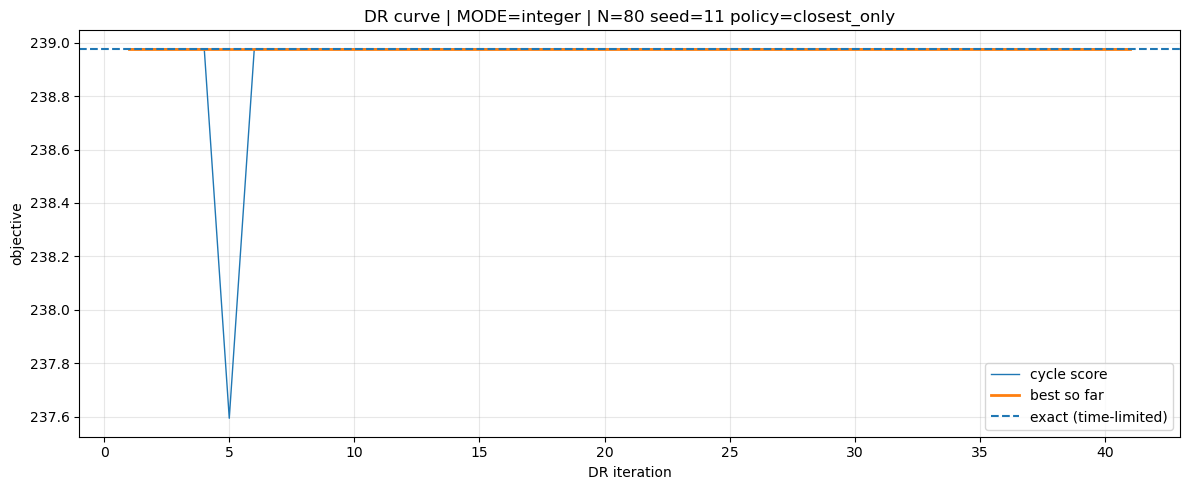

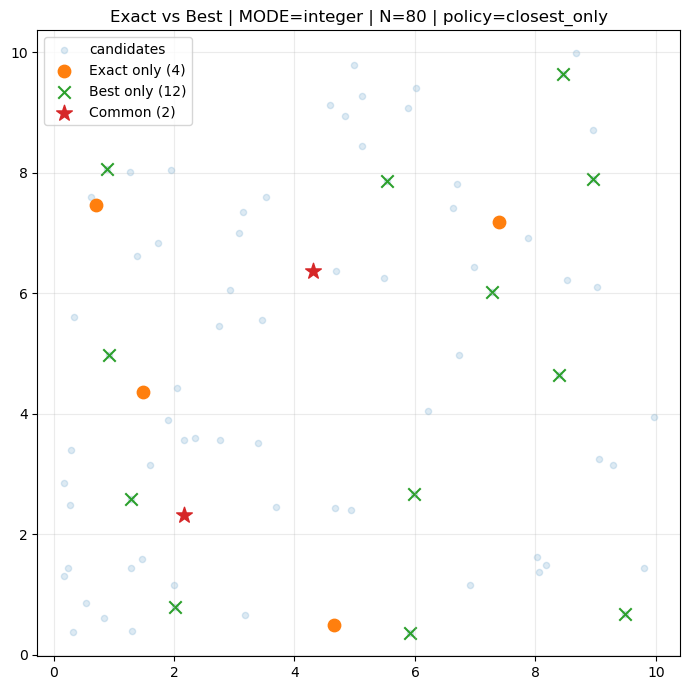

,metric,value
0,n_exact_open,6
1,n_best_open,14
2,n_common,2
3,only_exact,"[4, 6, 62, 64]"
4,only_best,"[0, 8, 22, 25, 37, 54, 58, 61, 67, 68, 72, 75]"
5,common,"[34, 39]"
6,total_units_exact,6
7,total_units_best,14


Saved: c:\Users\asus\OneDrive\EV-projects\evcs-projects\results_integer\compare_open_sets_N80_seed11_closest_only_integer.csv


,site,x_exact,x_best,diff_best_minus_exact
0,0,0,1,1
1,4,1,0,-1
2,6,1,0,-1
3,8,0,1,1
4,22,0,1,1
5,25,0,1,1
6,34,1,1,0
7,37,0,1,1
8,39,1,1,0
9,54,0,1,1


Saved: c:\Users\asus\OneDrive\EV-projects\evcs-projects\results_integer\charger_counts_exact_vs_best_N80_seed11_closest_only_integer.csv


,site,load_exact,load_best,x_exact,x_best,diff_best_minus_exact
0,34,25.643212,29.840269,1,1,4.197058
1,37,0.000000,29.403425,0,1,29.403425
2,22,0.000000,26.415023,0,1,26.415023
3,0,0.000000,24.878890,0,1,24.878890
4,58,0.000000,21.937304,0,1,21.937304
5,39,25.419144,17.510246,1,1,-7.908898
6,72,0.000000,17.507970,0,1,17.507970
7,75,0.000000,16.537496,0,1,16.537496
8,61,0.000000,13.477457,0,1,13.477457
9,8,0.000000,13.243049,0,1,13.243049


Saved: c:\Users\asus\OneDrive\EV-projects\evcs-projects\results_integer\loads_exact_vs_best_N80_seed11_closest_only_integer.csv


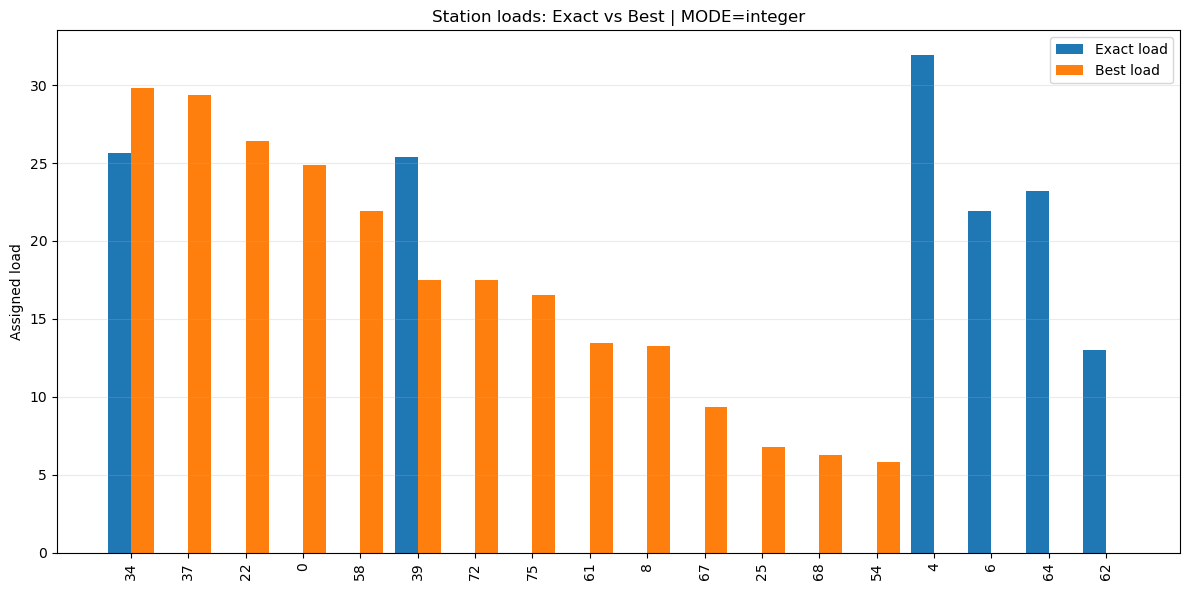

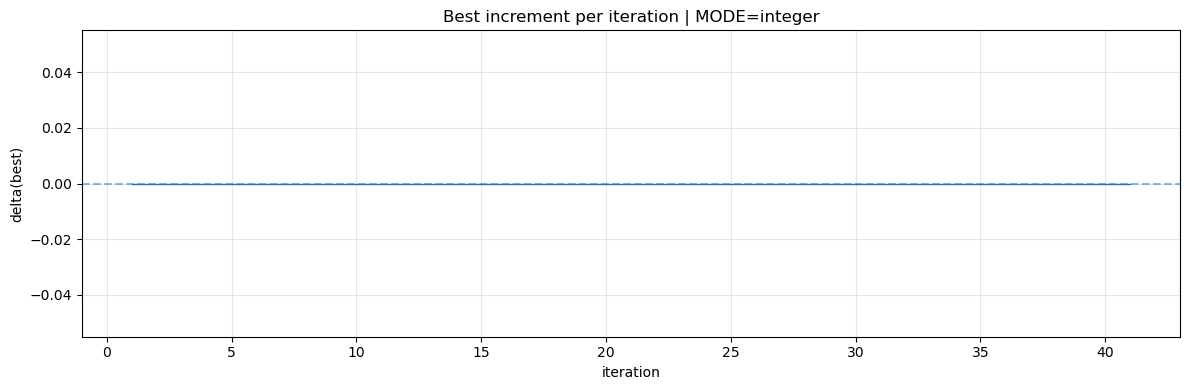

NameError: name 'default_parameters_for' is not defined

In [ ]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# ==========================
# PROJECT ROOT (fixed)
# ==========================
PROJECT_ROOT = Path.cwd().parents[0]   # notebooks/ → EVCS-PROJECTS/

# Add required paths
sys.path.insert(0, str(PROJECT_ROOT))
sys.path.insert(0, str(PROJECT_ROOT / "scripts"))
sys.path.insert(0, str(PROJECT_ROOT / "src"))

print("PROJECT_ROOT:", PROJECT_ROOT)

# Sanity check
assert (PROJECT_ROOT / "scripts" / "destruction_reconstruction.py").exists(), \
    "destruction_reconstruction.py not found"

# Project imports
from destruction_reconstruction import run_one_policy, default_parameters_binary, default_parameters_integer
from scripts.randomInstance import generate_instance, save_instance, load_instance

# =========================
# CHOOSE MODE HERE
# =========================
MODE = "integer"   # "binary" or "integer"

N = 80
seed = 11
policy = "closest_only"   # e.g. "closest_only", "closest_priority", ...

# DR settings
max_iter = 150
dr_time_limit = 900
dr_log_every = 1
greedy_mode = "W2"        # "deterministic" / "W1" / "W2"
destroy_mode = "demand_high"     # "random"/"area"/"cluster"/"demand_low"/"demand_high"

# Exact settings (time-limited baseline)
exact_time_limit = 600
exact_mip_gap = 0.005

# Integer-mode only settings
max_chargers_per_site = 5   # only used if MODE="integer"

if MODE == "binary":
    P, Q, D = default_parameters_binary(N)
else:
    P, Q, D = default_parameters_integer(N)



print("MODE:", MODE)
inst_dir = PROJECT_ROOT / "data" / "instances"
inst_dir.mkdir(parents=True, exist_ok=True)

inst_path = inst_dir / f"inst_N{N}_seed{seed}.json"
if inst_path.exists():
    inst = load_instance(str(inst_path))
    print("Loaded:", inst_path)
else:
    inst = generate_instance(N=N, seed=seed)
    save_instance(inst, str(inst_path))
    print("Generated & saved:", inst_path)

# =========================
# PARAMETERS (single source of truth)
# =========================
if MODE == "binary":
    P, Q, D = default_parameters_binary(N)
    allow_multi_charger = False
    max_chargers_per_site = None

elif MODE == "integer":
    # Start from binary calibration
    P_sites, Q, _ = default_parameters_binary(N)

    # HARDER integer regime (this is the key)
    P = int(1.2 * P_sites)   # NOT 2x or 3x
    D = 1.5                  # tighter coverage radius
    allow_multi_charger = True

else:
    raise ValueError("MODE must be 'binary' or 'integer'")

print(f"MODE={MODE} | P={P} | Q={Q:.2f} | D={D}")


print(f"P_sites(default)={P_sites}  -> using P={P}  | Q={Q:.3f}  D={D}")
out = run_one_policy(
    inst=inst,
    policy=policy,
    P=P, Q=Q, D=D,
    forbid_self=False,

    max_iter=max_iter,
    dr_time_limit=dr_time_limit,
    dr_log_every=dr_log_every,

    greedy_mode=greedy_mode,
    destroy_mode=destroy_mode,

    exact_time_limit=exact_time_limit,
    exact_mip_gap=exact_mip_gap,

    allow_multi_charger=allow_multi_charger,
    max_chargers_per_site=max_chargers_per_site if allow_multi_charger else None,

    seed=seed
)

print("score_exact:", out.get("score_exact"))
print("score_LS   :", out.get("score_LS"))
print("score_DR   :", out.get("score_DR"))

dr_df = out["DR_log"]
display(dr_df.head())
results_dir = PROJECT_ROOT / ("results_integer" if MODE=="integer" else "results_binary")
results_dir.mkdir(parents=True, exist_ok=True)

tag = f"N{N}_seed{seed}_{policy}_{MODE}"

dr_csv = results_dir / f"DR_log_{tag}.csv"
dr_df.to_csv(dr_csv, index=False)

summary = {
    "MODE": MODE,
    "N": N, "seed": seed, "policy": policy,
    "P": int(P), "Q": float(Q), "D": float(D),
    "max_iter": int(max_iter),
    "dr_time_limit": float(dr_time_limit),
    "greedy_mode": greedy_mode,
    "destroy_mode": destroy_mode,
    "exact_time_limit": float(exact_time_limit),
    "exact_mip_gap": float(exact_mip_gap),
    "score_exact": out.get("score_exact"),
    "score_LS": out.get("score_LS"),
    "score_DR": out.get("score_DR"),
    "time_exact": out.get("time_exact"),
    "time_LS": out.get("time_LS"),
    "max_chargers_per_site": int(max_chargers_per_site) if MODE=="integer" else None,
}

with open(results_dir / f"summary_{tag}.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

print("Saved:", dr_csv)
print("Saved summary json.")
plt.figure(figsize=(12,5))
plt.plot(dr_df["iteration"], dr_df["score"], label="cycle score", linewidth=1)
plt.plot(dr_df["iteration"], dr_df["best"], label="best so far", linewidth=2)

score_exact = out.get("score_exact", None)
if score_exact is not None and not (isinstance(score_exact, float) and np.isnan(score_exact)):
    plt.axhline(score_exact, linestyle="--", label="exact (time-limited)")

plt.title(f"DR curve | MODE={MODE} | N={N} seed={seed} policy={policy}")
plt.xlabel("DR iteration")
plt.ylabel("objective")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
def open_sites(m, mode):
    if m is None:
        return []
    if mode == "binary":
        return [int(j) for j in m.J if (m.x[j].value or 0.0) > 0.5]
    else:
        # integer: open if x[j] > 0
        return [int(j) for j in m.J if int(m.x[j].value or 0) > 0]

def charger_counts(m, mode):
    if m is None:
        return {}
    if mode == "binary":
        return {int(j): int((m.x[j].value or 0.0) > 0.5) for j in m.J}
    else:
        return {int(j): int(m.x[j].value or 0) for j in m.J}

def station_loads(m, demand_I, mode):
    if m is None:
        return {}
    opens = set(open_sites(m, mode))
    load = {j: 0.0 for j in opens}
    for (i, j) in m.Arcs:
        i = int(i); j = int(j)
        if j in load:
            load[j] += float(demand_I[i]) * float(m.y[i, j].value or 0.0)
    return load

def plot_open_sets(coords_J, open_exact, open_best, title="Exact vs Best"):
    coords_J = np.asarray(coords_J)

    setE, setB = set(open_exact), set(open_best)
    onlyE = sorted(list(setE - setB))
    onlyB = sorted(list(setB - setE))
    common = sorted(list(setE & setB))

    plt.figure(figsize=(7,7))
    plt.scatter(coords_J[:,0], coords_J[:,1], s=20, alpha=0.15, label="candidates")

    if onlyE:
        pts = coords_J[onlyE]
        plt.scatter(pts[:,0], pts[:,1], s=80, marker="o", label=f"Exact only ({len(onlyE)})")
    if onlyB:
        pts = coords_J[onlyB]
        plt.scatter(pts[:,0], pts[:,1], s=80, marker="x", label=f"Best only ({len(onlyB)})")
    if common:
        pts = coords_J[common]
        plt.scatter(pts[:,0], pts[:,1], s=140, marker="*", label=f"Common ({len(common)})")

    plt.title(title)
    plt.axis("equal")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {"only_exact": onlyE, "only_best": onlyB, "common": common}

m_exact = out.get("m_exact", None)
m_best  = out.get("m_best", None)

coords_J = inst["coords_J"]
demand_I = inst["demand_I"]

open_e = open_sites(m_exact, MODE)
open_b = open_sites(m_best, MODE)

cmp = plot_open_sets(
    coords_J,
    open_exact=open_e,
    open_best=open_b,
    title=f"Exact vs Best | MODE={MODE} | N={N} | policy={policy}"
)

x_e = charger_counts(m_exact, MODE)
x_b = charger_counts(m_best, MODE)

cmp_table = pd.DataFrame({
    "metric": ["n_exact_open", "n_best_open", "n_common", "only_exact", "only_best", "common",
               "total_units_exact", "total_units_best"],
    "value": [
        len(open_e), len(open_b), len(cmp["common"]),
        str(cmp["only_exact"]), str(cmp["only_best"]), str(cmp["common"]),
        sum(x_e.values()), sum(x_b.values())
    ]
})
display(cmp_table)

cmp_csv = results_dir / f"compare_open_sets_{tag}.csv"
cmp_table.to_csv(cmp_csv, index=False)
print("Saved:", cmp_csv)

# Charger count table (integer mode is meaningful; binary will just be 0/1)
xc_df = pd.DataFrame({
    "site": sorted(set(open_e) | set(open_b)),
    "x_exact": [x_e.get(j, 0) for j in sorted(set(open_e) | set(open_b))],
    "x_best":  [x_b.get(j, 0) for j in sorted(set(open_e) | set(open_b))],
})
xc_df["diff_best_minus_exact"] = xc_df["x_best"] - xc_df["x_exact"]
display(xc_df)

xc_csv = results_dir / f"charger_counts_exact_vs_best_{tag}.csv"
xc_df.to_csv(xc_csv, index=False)
print("Saved:", xc_csv)

load_e = station_loads(m_exact, demand_I, MODE)
load_b = station_loads(m_best, demand_I, MODE)

stations_union = sorted(list(set(load_e.keys()) | set(load_b.keys())))

loads_df = pd.DataFrame({
    "site": stations_union,
    "load_exact": [load_e.get(j, 0.0) for j in stations_union],
    "load_best":  [load_b.get(j, 0.0) for j in stations_union],
    "x_exact":    [charger_counts(m_exact, MODE).get(j, 0) for j in stations_union],
    "x_best":     [charger_counts(m_best, MODE).get(j, 0) for j in stations_union],
})
loads_df["diff_best_minus_exact"] = loads_df["load_best"] - loads_df["load_exact"]

# sort by best load descending
loads_df = loads_df.sort_values("load_best", ascending=False).reset_index(drop=True)
display(loads_df)

loads_csv = results_dir / f"loads_exact_vs_best_{tag}.csv"
loads_df.to_csv(loads_csv, index=False)
print("Saved:", loads_csv)

